<a href="https://colab.research.google.com/github/fsheee/handoff_orchestration_openAI_SDk/blob/main/handoff_asyncio_context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq openai-agents pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00


In [2]:
import nest_asyncio
nest_asyncio.apply()

In [8]:
import os
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel
from agents.run import RunConfig
from google.colab import userdata


gemini_api_key = userdata.get("GEMINI_API_KEY")


# Check if the API key is present; if not, raise an error
if not gemini_api_key:
    raise ValueError("GEMINI_API_KEY is not set. Please ensure it is defined in your .env file.")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

config = RunConfig(
    model=model,
    model_provider=external_client,
    tracing_disabled=True
)

In [65]:
import asyncio
from agents import Agent, Runner, function_tool,RunContextWrapper
# from agents.tools import tool
from pydantic import BaseModel

# Define a custom context class
class UserContext(BaseModel):
    user_id: str
    session_id: str

# Define a tool to fetch user data
@function_tool
async def get_user_data(wrapper: RunContextWrapper[UserContext]) -> str:
    """Fetch user account details based on user ID."""

    return f"User {wrapper.context.user_id}: Account active, balance $50, last login 2025-06-10."

# Define specialized agents
balance_agent = Agent(
    name="Balance Agent",
    instructions="You handle balance-related queries. when asked about account details,use the get_user_data tool to retrive the user's data and provide their current balance or account balance and data of their last login.",
    tools=[get_user_data],

)

tech_agent = Agent(
    name="Technical Support Agent",
    instructions="You handle technical support queries. Provide helpful troubleshooting advice.",

)

# Define the triage agent
triage_agent = Agent(
    name="Triage Agent",
    instructions="Analyze the query and delegate to the Billing Agent for billing issues or Technical Support Agent for technical issues. Use the context to access the user ID.",
    handoffs=[balance_agent, tech_agent],

)

# Run the workflow
async def main():
    # Create a context instance
  context1 = UserContext(user_id="12345", session_id="session_67890")

    # Example 1: Billing query
  result = await Runner.run(
        starting_agent=triage_agent,
        input="tell me about my account balance.",
        context=context1,
        # Pass the 'config' object to the run method
        run_config=config
    )
  print("Balance Query Result:", result.final_output)
  print(result.last_agent.name)

  #   # # Example 2: Technical query
  # result = await Runner.run(
  #       starting_agent=triage_agent,
  #       input="My app is crashing. Can you help?",
  #       context=context1,
  #       # Pass the 'config' object to the run method
  #       run_config=config
  #   )
  # print("Technical Query Result:", result.final_output)
  # print(result.last_agent.name)

# Execute the async main function
if __name__ == "__main__":
  asyncio.run(main())

Balance Query Result: Your account balance is $50. You last logged in on 2025-06-10.

Balance Agent


In [38]:
import asyncio
from agents import Agent, Runner, function_tool,RunContextWrapper
# from agents.tools import tool
from pydantic import BaseModel

# Define a custom context class
class UserContext(BaseModel):
    user_id: str
    session_id: str

# Define a tool to fetch user data
@function_tool
async def get_user_data(wrapper: RunContextWrapper[UserContext]) -> str:
    """Fetch user account details based on user ID."""

    return f"User {wrapper.context.user_id}: Account active, balance $50, last login 2025-06-10."

# Define specialized agents
balance_agent = Agent(
    name="Balance Agent",
    instructions="You handle balance-related queries. when asked about account details,use the get_user_data tool to retrive the user's data and provide their balance and data of their last login.",
    tools=[get_user_data],

)

tech_agent = Agent(
    name="Technical Support Agent",
    instructions="You handle technical support queries. Provide helpful troubleshooting advice.",

)

# Define the triage agent
triage_agent = Agent(
    name="Triage Agent",
    instructions="Analyze the query and delegate to the Billing Agent for billing issues or Technical Support Agent for technical issues. Use the context to access the user ID.",
    handoffs=[balance_agent, tech_agent],

)

# Run the workflow
async def main():
    # Create a context instance
  context1 = UserContext(user_id="12345", session_id="session_67890")

    # # Example 2: Technical query
  result = await Runner.run(
        starting_agent=triage_agent,
        input="My app is crashing. Can you help?",
        context=context1,
        # Pass the 'config' object to the run method
        run_config=config
    )
  print("Technical Query Result:", result.final_output)
  print(result.last_agent.name)

# Execute the async main function
if __name__ == "__main__":
  asyncio.run(main())

Technical Query Result: Okay, I can help with that! App crashes can be frustrating, so let's try to figure out what's going on. To give you the best advice, I need some more information. Please tell me:

*   **What is the name of the app?**
*   **What device are you using? (e.g., iPhone 13, Samsung Galaxy S21, iPad Air, etc.)**  Knowing the device and operating system version (e.g., iOS 16.5, Android 12) is really helpful.
*   **What were you doing in the app when it crashed?** (e.g., "I was trying to upload a photo," "I was just browsing the main screen," "It crashed as soon as I opened it.")
*   **Is this the first time the app has crashed?**  If not, how often does it crash?
*   **Have you tried any troubleshooting steps already?** (e.g., restarting the app, restarting your device, reinstalling the app). If so, what were the results?
*   **Are there any error messages?**  If so, please provide the exact error message.  Even a partial error message can be useful.

Once I have this in

In [66]:
pip install -q "openai-agents[viz]"

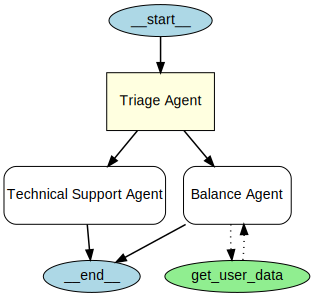

In [67]:
from agents.extensions.visualization import draw_graph
draw_graph(triage_agent)